In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import lstm_encoder_decoder_no_early

In [15]:
import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pickle

import numpy as np
import pandas as pd
import random
import math

import gc
import os, os.path 
import pickle
from glob import glob
import matplotlib.pyplot as plt
import time

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- val: 55029 test:7971
    # pittsburgh -- val: 43544 test: 6361
    # dearborn -- val: 24465 test: 3671
    # washington-dc -- val: 25744 test: 3829
    # palo-alto -- val:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- val: 55029 test:7971\n    # pittsburgh -- val: 43544 test: 6361\n    # dearborn -- val: 24465 test: 3671\n    # washington-dc -- val: 25744 test: 3829\n    # palo-alto -- val:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [45]:
ROOT_PATH = "../../argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test", "val"] 

# def get_city_trajectories(city="palo-alto", split="train", SEED=42):

#     outputs = None
    
#     if split=="train":
#         f_in = ROOT_PATH + split + "/" + city + "_inputs"
#         inputs = pickle.load(open(f_in, "rb"))
#         n = len(inputs)

#         np.random.seed(SEED)
#         shuffler = np.random.permutation(n)
        
#         inputs = np.asarray(inputs)
# #         inputs = inputs[shuffler]
#         inputs = inputs[:int(n * 0.8)]
        
#         f_out = ROOT_PATH + split + "/" + city + "_outputs"
#         outputs = pickle.load(open(f_out, "rb"))
#         outputs = np.asarray(outputs)
# #         outputs = outputs[shuffler]
#         outputs = outputs[:int(n * 0.8)]
        
#     elif split == 'val':
#         f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
#         inputs = pickle.load(open(f_in, "rb"))
#         n = len(inputs)

# #         np.random.seed(SEED)
# #         shuffler = np.random.permutation(n)
        
#         inputs = np.asarray(inputs)
# #         inputs = inputs[shuffler]
#         inputs = inputs[int(n * 0.8):]
        
#         f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
#         outputs = pickle.load(open(f_out, "rb"))
#         outputs = np.asarray(outputs)
# #         outputs = outputs[shuffler]
#         outputs = outputs[int(n * 0.8):]
    
#     else:
#         f_in = ROOT_PATH + split + "/" + city + "_inputs"
#         inputs = pickle.load(open(f_in, "rb"))
#         n = len(inputs)
#         inputs = np.asarray(inputs)
#         outputs = torch.zeros(n,60, 2).to(device)

#     return inputs, outputs
def get_city_trajectories(city="palo-alto", split="train", SEED=42):

    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)

        np.random.seed(SEED)
        shuffler = np.random.permutation(n)
        
        inputs = np.asarray(inputs)
        inputs = inputs[shuffler]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        outputs = outputs[shuffler]
        

    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
        outputs = torch.zeros(n,60, 2).to(device)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.split = split
        self.input_positions, self.output_positions = get_city_trajectories(city=city, split=split)
        
        self.input_positions = torch.Tensor(self.input_positions)
        num_inputs, input_seq_len = self.input_positions.shape[:2]
        self.center_input = (
            np.repeat(self.input_positions[:, 0, :], input_seq_len, axis=0)
            .reshape(num_inputs, input_seq_len, 2)
        )
        self.center = (
            np.repeat(self.input_positions[:, 0, :], 60, axis=0)
            .reshape(num_inputs, 60, 2)
        )
#         print(self.center.shape)
#         print(self.center[:1])
        self.input_positions_centered = torch.Tensor(self.input_positions - self.center_input)
        self.input_velocities = torch.Tensor(np.diff(self.input_positions, axis=1))
        
        self.nn_pos_inputs = self.input_positions_centered
        self.nn_velo_inputs = self.input_velocities
        
        if split != 'test': 
            self.output_positions = torch.Tensor(self.output_positions)
            num_outputs, output_seq_len = self.output_positions.shape[:2]
            center_output = (
                np.repeat(self.input_positions[:, 0, :], output_seq_len, axis=0)
                .reshape(num_outputs, output_seq_len, 2)
            )
            self.output_positions_centered = torch.Tensor(self.output_positions - center_output)
            self.output_velocities = torch.Tensor(np.diff(self.output_positions, axis=1))
                    
            self.nn_pos_outputs = self.output_positions_centered[:, 0, :].unsqueeze(1)
            self.nn_velo_outputs = self.output_velocities

    def __len__(self):
        return len(self.nn_pos_inputs)

    def __getitem__(self, idx):
        if self.split != 'test':
            data = (
                self.nn_pos_inputs[idx], 
                self.nn_pos_outputs[idx], 
                self.nn_velo_inputs[idx], 
                self.nn_velo_outputs[idx],
                self.input_positions[idx],
                self.output_positions[idx],
                self.input_positions_centered[idx],
                self.output_positions_centered[idx],
                self.center[idx]

            )
        else:
            data = data = (
                self.nn_pos_inputs[idx], 
                self.nn_velo_inputs[idx], 
                self.center[idx]
            )
        return data

In [46]:
train_dataset = ArgoverseDataset(city='austin', split='train')

In [47]:
!nvidia-smi

Sat Jun  4 16:37:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 460.67                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:85:00.0 Off |                  N/A |
| 23%   31C    P8     9W / 250W |    857MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [48]:
# function that tells how long training takes
def train_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs 

In [20]:

for city in cities:
    test_dataset = ArgoverseDataset(city=city, split='test')
    rows = []


    nn_pos_nth_input, nn_velo_nth_input, center_input = test_dataset.__getitem__(n)
    nn_pos_nth_input = nn_pos_nth_input.to(device)
    nn_velo_nth_input = nn_velo_nth_input.to(device)
    center_input = center_input.to(device)
    init_pos = lstm_encoder_decoder_no_early.predict(model_pos, nn_pos_nth_input, 1, device=device)
    deltas = lstm_encoder_decoder_no_early.predict(model_velo, nn_velo_nth_input, 59, device=device)

    pred = (torch.cumsum(torch.cat((init_pos, deltas)), dim=0).flatten() + center_input).cpu().numpy()
    rows.append(pred)
    ids = np.array([str(i) + '_' + city for i in range(len(rows))])
    cols = np.array(['v' + str(i) for i in range(120)])
    predictions = pd.DataFrame(rows, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
all_predictions = pd.concat(all_preds, ignore_index=True)

NameError: name 'n' is not defined

In [49]:
import lstm_encoder_decoder_no_early

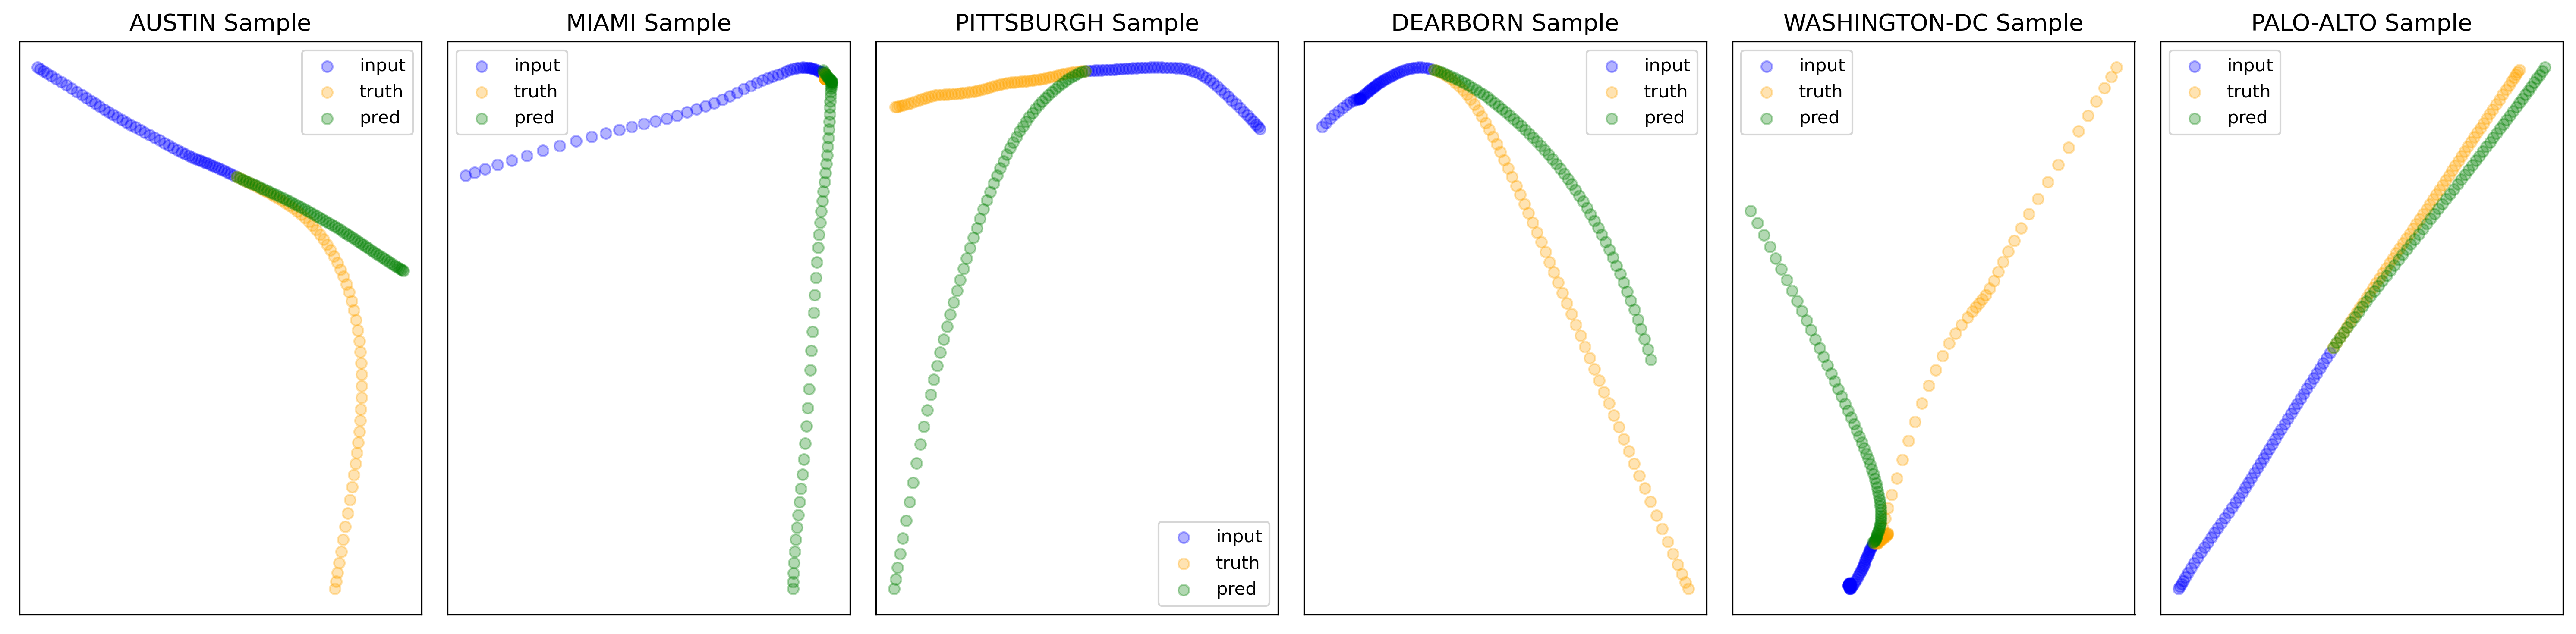

In [50]:
num_layers_pos = 1
num_layers_velo = 1
device = torch.device('cpu')

cols = np.array(['v' + str(i) for i in range(120)])
batch_size = 128
fig, axs = plt.subplots(1,6, figsize=(20,5), facecolor='w', edgecolor='k', dpi =300 )
# fig.subplots_adjust(hspace = .5, wspace=0.0001)

axs = axs.ravel()
for city, i in zip(cities, range(6)):

    #loading model
    load_pred_pos = pickle.load(open('../models/seq2seq_lstm_pos_atten_1000_1_' + city, 'rb'))
    load_pred_velo = pickle.load(open('../models/seq2seq_lstm_velo_atten_1_' + city, 'rb'))
    load_pred_pos = load_pred_pos.to(device)
    load_pred_velo = load_pred_velo.to(device)
    load_pred_pos.eval()
    load_pred_velo.eval()

    train_dataset_w = get_city_trajectories(city = city, split = 'train')
    train_dataset = ArgoverseDataset(city=city, split='train')
    
    
    preds_numpy = train_dataset_w[0].shape[0]
    

    #get the training dataset/ return inputs, ouputs
    sample = 27#random.randint(0,preds_numpy) 
    
    samp_1_inp = train_dataset_w[0][sample]
    samp_1_truth = train_dataset_w[1][sample]

    nn_pos_nth_input,nn_pos_nth_output, nn_velo_nth_input,nn_velo_nth_output,_,_,_,_,center_input = train_dataset.__getitem__(sample)
    nn_pos_nth_input = nn_pos_nth_input.to(device)
    nn_velo_nth_input = nn_velo_nth_input.to(device)
#     print(nn_pos_nth_input.shape)
    center_input = center_input.to(device)
    samp_1_pred_pos = lstm_encoder_decoder_no_early.predict(load_pred_pos,nn_pos_nth_input,1)
    samp_1_pred_velo = lstm_encoder_decoder_no_early.predict(load_pred_velo,nn_velo_nth_input,59)

#     print(samp_1_pred_pos)
#     print(center_input)
#     print(samp_1_pred_velo)
    samp_1_pred = (torch.cumsum(torch.cat((samp_1_pred_pos, samp_1_pred_velo)), dim=0)+ center_input).cpu().detach().numpy()
#     print(samp_1_pred)
#     print(samp_1_truth)
    
    
    axs[i].set_title(city + ' Sample',fontsize =13)
    axs[i].xaxis.set_ticks([])
    axs[i].yaxis.set_ticks([])
    axs[i].scatter(samp_1_inp[:,0], samp_1_inp[:,1], color = 'blue', label= 'input', alpha= .3)
    axs[i].scatter(samp_1_truth[:,0], samp_1_truth[:,1], color = 'orange',label= 'truth', alpha= .3)
    axs[i].scatter(samp_1_pred[:,0], samp_1_pred[:,1], color = 'green',label= 'pred', alpha= .3)
    axs[i].legend(loc='best')

fig.suptitle("Seq2Seq LSTM with ", fontsize = 20)
plt.tight_layout()
# train_pred = pd.concat(all_preds, ignore_index = True)
# train_pred